## Analysis of Token Based Features

In [3]:
import sys
sys.path.append('../')
import libs.utils as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import seaborn as sns
import libs.feature_analysis as fa
from sklearn.manifold import TSNE
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [5]:
df = pd.read_csv('../datasets/features/asag_v1_en.csv', sep='~')
df1_en = pd.read_csv('../datasets/normal/asag_v1_en.csv', sep='~')
df.head(3)

cols = df.columns.tolist()
cols.remove('GID')
cols.remove('Score')
bdf_orig = df[cols]

scores = df['Score'].as_matrix().copy()
scores = utils.convert_to_class4(scores)
scores_3c = df['Score'].as_matrix().copy()
scores_3c = utils.convert_to_class3(scores_3c)
scores_2c = df['Score'].as_matrix().copy()
scores_2c = utils.convert_to_class2(scores_2c)

# Touch up dataset
bdf = bdf_orig.copy()
bdf = bdf.replace([np.inf, -np.inf], np.nan)
bdf['Tkn_Cosine'] = bdf['Tkn_Cosine'].fillna(0.0)
bdf['WMD'] = bdf['WMD'].fillna(0.0)

# Normalize
bdf['Tree_ED'] = utils.min_max_normalization(bdf['Tree_ED'].as_matrix())
bdf['Length_Diff'] = utils.min_max_normalization(bdf['Length_Diff'].as_matrix())

# 
cmp = bdf.copy()
cmp['Score'] = scores
cmp['Score3'] = scores_3c
cmp['Score2'] = scores_2c
cmp.head(2)

Bleu_Score        ED    POS_ED  DepParse_ED   Tree_ED  Tkn_Cosine  \
0   2.272393e-32  0.857143  0.714286     0.785714  0.172589     0.53936   
1  2.172090e-124  0.750000  0.583333     0.583333  0.467005     0.40452   

    NGram_1   NGram_2   NGram_3   BoW_Cos   BoW_JSD  Length_Diff       WMD  \
0  0.315789  0.598408  0.630957  0.381385  0.380280     0.750000  2.077197   
1  0.250000  0.333333  0.000000  0.478091  0.395186     0.777778  2.250237   

   Vec_Cosine    KB_WUP    KB_JNC  Score  Score3  Score2  
0    0.734018  1.076923  1.000000    2.0     2.0     1.0  
1    0.717958  0.917904  0.590004    1.0     1.0     1.0

In [9]:
token_cols = ['Tkn_Cosine', 'NGram_1','NGram_2','NGram_3', 'BoW_Cos', 'BoW_JSD']
fs_tokens = bdf[token_cols].as_matrix() 
res = TSNE(n_components=2, random_state=42, perplexity=45).fit_transform(fs_tokens)

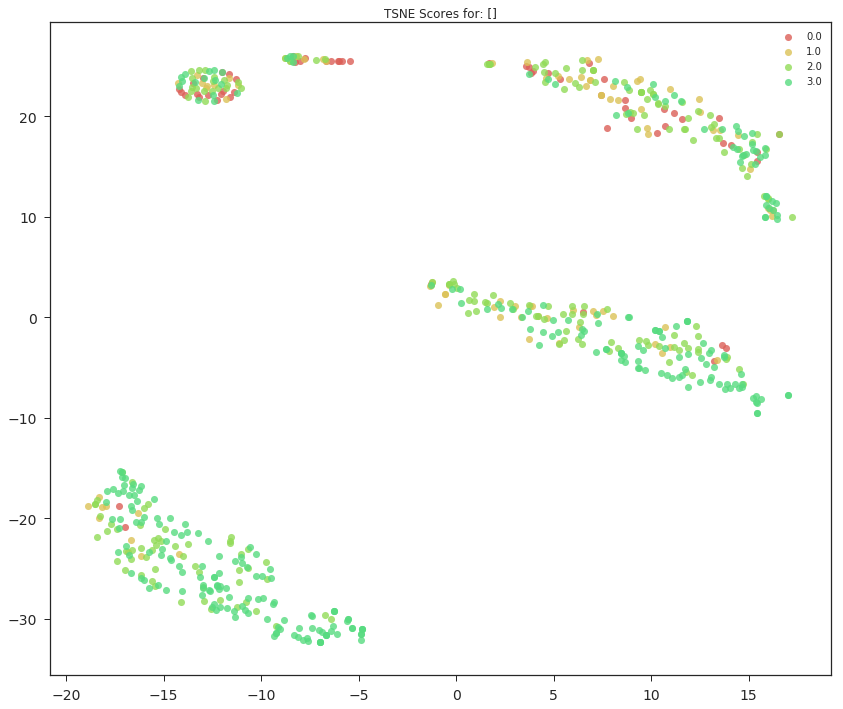

In [11]:
reload(fa)
fa.plot_tsne(res, scores)

## Bottom Left Cluster:

1. What makes a question wrong in this cluster?
2. Why are all the questions graded relatively high?

In [55]:
reload(fa)
idxs = fa.select_indexes_from_tsne(df1_en, res, xbox=[-30,-4],ybox=[-50,-10])

def display_row(row, feat_row):
    print('[{}.{}]: {}'.format(row['AID'], row['QID'], row['Prompt']))
    print('MA: {}'.format(row['Model Answer']))
    print('SA: {}'.format(row['Student Answer']))
    print('Score: {}'.format(row['Score']))
    print('Token Cosine: {}'.format(feat_row['Tkn_Cosine']))
    print('NGRAM_1: {:.2f}'.format(feat_row['NGram_1']))
    print('NGRAM_2: {:.2f}'.format(feat_row['NGram_2']))
    print('NGRAM_3: {:.2f}'.format(feat_row['NGram_3']))
    print('BoW Cosine: {:.2f}'.format(feat_row['BoW_Cos']))
    print()

def inspect_entries(df, fdf):
    g = df[['AID','QID','Score', 'Student Answer']].groupby(['AID', 'QID'])
    print(g.agg(['mean', 'count']))  
    for index in range(len(df)):
        orig = df.iloc[index]
        feat = fdf.iloc[index]
        display_row(orig, feat)


bad_scores = df1_en[idxs]['Score'] < 3
c1 = cmp[idxs][bad_scores]
t1 = df1_en[idxs][bad_scores]
print(c1[['Tkn_Cosine','BoW_Cos', 'NGram_1', 'NGram_2', 'NGram_3']].describe())

inspect_entries(t1, c1)

       Tkn_Cosine   BoW_Cos   NGram_1   NGram_2   NGram_3
count    4.000000  4.000000  4.000000  4.000000  4.000000
mean     0.312373  0.434951  0.194628  0.398763  0.493039
std      0.059186  0.090055  0.070157  0.078505  0.109356
min      0.224544  0.317554  0.103448  0.311766  0.349051
25%      0.306136  0.395741  0.159791  0.359009  0.447715
50%      0.335698  0.445790  0.205952  0.391643  0.507371
75%      0.341935  0.484999  0.240789  0.431397  0.552695
max      0.353553  0.530669  0.263158  0.500000  0.608364
        Score      
         mean count
AID QID            
2   6    2.50     1
3   2    1.50     1
    6    2.25     2
[2.6]: What is the difference between a function prototype and a function definition?
MA: A function prototype includes the function signature, i.e., the name of the function, the return type, and the parameters' type. The function definition includes the actual body of the function.
SA: The FUNCTION PROTOTYPE is where the programmer declares that he/she i

### Bottom Cluster: Bad Scores Interpretation

1. The bad scores in the bottom cluster occur when:
2. Students enter relatively long incorrect questions, which have high Bigram and Trigram matches but lower unigram matches.
3. The Cosine similarity and BoW scores are relatively high.
3. Interpretation: Structurally (at a token level) these answers are very similar to good answers, they are just missing some semantic content which would make them correct.

### What makes good scores in this cluster?

1. Look at the average difference b/t NGRAM1-3, Bow and Tkn_Cosine.

In [58]:
good_scores = df1_en[idxs]['Score'] >= 4.5
c2 = cmp[idxs][good_scores]
t2 = df1_en[idxs][good_scores]

display(c2[['Tkn_Cosine','BoW_Cos', 'NGram_1', 'NGram_2', 'NGram_3']].describe())

Tkn_Cosine     BoW_Cos     NGram_1     NGram_2     NGram_3
count  163.000000  163.000000  163.000000  163.000000  163.000000
mean     0.542406    0.574386    0.398739    0.559304    0.608901
std      0.207721    0.209378    0.162559    0.148086    0.132864
min      0.000000    0.000000    0.104167    0.337553    0.412234
25%      0.396188    0.445982    0.278889    0.449644    0.513533
50%      0.559017    0.577350    0.379310    0.516679    0.570825
75%      0.670820    0.707107    0.500000    0.642339    0.686211
max      1.000000    1.000000    1.000000    1.000000    1.000000

It looks like when there is not as much difference b/t the NGRAM1-3 values and the Token Cosine and BoW Cosine Means.

In [80]:
examples = np.random.choice(t2.index.tolist(),size=20)
inspect_entries(t2.loc[examples], c2.loc[examples])

            Score      
             mean count
AID QID                
1   1    4.900000     5
    3    4.750000     2
    6    5.000000     3
    7    5.000000     1
2   6    4.833333     3
3   5    5.000000     2
    6    5.000000     1
    7    5.000000     3
[1.1]: What does a function signature include?
MA: The name of the function and the types of the parameters.
SA: the name of the function and its parameters
Score: 5.0
Token Cosine: 0.7999999999999998
NGRAM_1: 0.75
NGRAM_2: 0.77
NGRAM_3: 0.82
BoW Cosine: 0.80

[1.1]: What does a function signature include?
MA: The name of the function and the types of the parameters.
SA: The name of the function and the types of its arguments.This includes the number, type, and order the parameters appear in.
Score: 5.0
Token Cosine: 0.6741998624632421
NGRAM_1: 0.47
NGRAM_2: 0.75
NGRAM_3: 0.80
BoW Cosine: 0.76

[3.5]: What is a variable?
MA: A location in memory that can store a value.
SA: A variable is a value that is subject to change in a c